To run spark in Colab, first there are some the dependencies that need to be installed in the Colab environment:
 1. Apache Spark 2.3.4
 2. Hadoop 2.7
 3. Java 8
 4. Findspark in order to locate the spark in the system

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

     |████████████████████████████████| 204kB 4.7MB/s 


Now that Spark and Java are installed in Colab, it is time to set the environment path that enables running PySpark in the Colab environment. The following code sets the location of Java and Spark:

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

Running a spark session:


In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

The following code segment defines a starting set of sentences

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

sentenceData = spark.createDataFrame([
                                      (0, "Tropical fish include fish found in tropical environments around the world, including both freshwater and salt water species. Tropical fish are popular as aquarium fish, due to their often bright coloration. In freshwater fish, this coloration typically derives from iridescence, while salt water fish are generally pigmented. Fishkeepers often use the term tropical fish to refer particularly to those requiring fresh water, with saltwater tropical fish referred to as marine fish. Tropical fish kept for home aquaria include the following: ⁕Wild-caught specimens. ⁕Single-species individuals born in captivity. The latter category includes lines selectively bred for special physical features, such as long fins, or particular colorations, such as albino. ⁕Hybrids of more than one species. Recreational SCUBA divers are often enthusiasts of tropical fish as well. Some keep lists of fish species they have observed while diving, especially in tropical marine environments."),
                                      (1, "Tropical fish is a term commonly used to refer to fish that are kept in heated aquariums. Freshwater tropical fish are more commonly kept than saltwater tropical fish due to the common availability of fresh water sources, such as tap water, whereas salt water is not commonly available and has to be recreated by using fresh water with sea salt additions. Salt water has to be monitored to maintain the correct salinity because of the effects of evaporation. Freshwater tropical aquariums can be maintained by simply topping up with fresh water. Tropical fish are popular choices for aquariums due to their often bright coloration, which typically derives from both pigmented cells and iridescent cells.[1] Tropical fish may include wild-caught specimens, individuals born in captivity including lines selectively bred for special physical features, such as long fins, or particular colorations, such as albino. Some fish may be hybrids of more than one species."),
                                      (2, "Most fish that are sold as tropical fish are freshwater species. Most species available are generally bred from fish farms in the far east and Florida where tropical temperatures make the commercial production more viable. Mass production of tropical fish from farms has led to many inexpensive fish available to aquarists. Tropical freshwater fish are the most popular group of fish because of the low price and ease of keeping in aquaria. Some species are difficult to breed in captivity and so are still sourced from the wild. These species are generally more expensive. Among the bred-in-captivity species, the most expensive freshwater species include arowanas and flowerhorn cichlids. Some male flowerhorns are sterile due to many cross breedings."),
                                      (3, "Marine fish that are sold as tropical fish are generally sourced from the wild, usually from the coral reefs around the world. This is because only a few species of marine fish have been successfully bred in captivity with any regularity. The price of marine fish coupled with the difficulty in keeping them alive in aquaria makes them less of a popular choice for aquarists to keep. However, because of the more vivid colours, patterns and behaviour of marine fish compared to freshwater fish, they are still reasonably popular. The advances in filtration technology and increase in available knowledge on how to maintain marine fish as well as the increasing number of aquarium-bred species is seeing a gradual rise in their popularity.")
                                      ],["id", "sentence"]) 

This set is then splitted into words using *Tokenizer*. For each bag of words, HashingTF is used to hash the sentence into a feature vector. IDF rescales the feature vectors; this generally improves performance when using text as features. This feature vectors could then be passed to a learning algorithm.

In [5]:
#Split dataFrame by spaces using an standard tokenizer
tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
sentenceDataSplitted = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(sentenceDataSplitted)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("id","words", "features").show()

+---+--------------------+--------------------+
| id|               words|            features|
+---+--------------------+--------------------+
|  0|[tropical, fish, ...|(20,[0,1,2,3,4,5,...|
|  1|[tropical, fish, ...|(20,[0,1,2,3,4,5,...|
|  2|[most, fish, that...|(20,[0,1,2,3,4,5,...|
|  3|[marine, fish, th...|(20,[0,1,2,3,4,5,...|
+---+--------------------+--------------------+



In [6]:
from pyspark.ml.feature import CountVectorizer

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=3, minDF=2.0)

model = cv.fit(sentenceDataSplitted)

result = model.transform(sentenceDataSplitted)
result.show(truncate=True)

+---+--------------------+--------------------+--------------------+
| id|            sentence|               words|            features|
+---+--------------------+--------------------+--------------------+
|  0|Tropical fish inc...|[tropical, fish, ...|(3,[0,1,2],[9.0,4...|
|  1|Tropical fish is ...|[tropical, fish, ...|(3,[0,1,2],[7.0,3...|
|  2|Most fish that ar...|[most, fish, that...|(3,[0,1,2],[7.0,7...|
|  3|Marine fish that ...|[marine, fish, th...|(3,[0,1,2],[6.0,8...|
+---+--------------------+--------------------+--------------------+



In [0]:
#@title Vector plot

import numpy as np
import matplotlib.pyplot as plt
def plotv(M):
    rows,cols = M.T.shape
    print(rows,cols)

    #Get absolute maxes for axis ranges to center origin
    #This is optional
    maxes = 1.1*np.amax(abs(M), axis = 0)
    colors = ['b','r','k']
    fig = plt.figure()

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_title('Vector similarity')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    for i,l in enumerate(range(0,cols)):
        # print(i)
        plt.axes().arrow(0,0,M[i,0],M[i,1],head_width=0.2,head_length=0.1,zorder=3)

        ax.text(M[i,0],M[i,1], "doc "+str(i), style='italic',
            bbox={'facecolor':'red', 'alpha':0.5, 'pad':0.5})

    plt.plot(0,0,'ok') #<-- plot a black point at the origin
    # plt.axis('equal')  #<-- set the axes to the same scale
    plt.xlim([-maxes[0],maxes[0]]) #<-- set the x axis limits
    plt.ylim([-maxes[1],maxes[1]]) #<-- set the y axis limits

    plt.grid(b=True, which='major') #<-- plot grid lines
    plt.show()

In [0]:
from pyspark.ml.feature import Word2Vec

# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="words", outputCol="result")
model = word2Vec.fit(sentenceDataSplitted)

result = model.transform(sentenceDataSplitted)
vectors = []
for row in result.collect():
    id, sentence, words, vector = row
    vectors.append([(100*vector[0]),(100*vector[1])])

vectors = np.asarray(vectors)

2 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


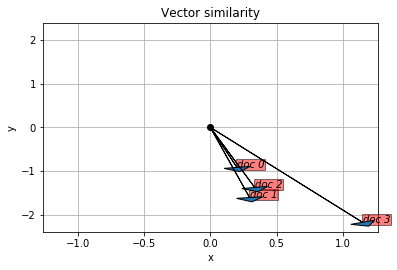

In [31]:
plotv(vectors)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# vectors
a = vectors[0]
b = vectors[1]
c = vectors[2]
d = vectors[3]

# use library, operates on sets of vectors
a = a.reshape(1,2)
b = b.reshape(1,2)
c = c.reshape(1,2)
d = d.reshape(1,2)

cos_lib = cosine_similarity(a, b) 
print('Similarity between doc0,doc1: ', cos_lib[0][0]*100)
cos_lib = cosine_similarity(a, c)
print('Similarity between doc0,doc2: ', cos_lib[0][0]*100)
cos_lib = cosine_similarity(a, d)
print('Similarity between doc0,doc3: ', cos_lib[0][0]*100)
cos_lib = cosine_similarity(b, c)
print('Similarity between doc1,doc2: ', cos_lib[0][0]*100)
cos_lib = cosine_similarity(b, d)
print('Similarity between doc1,doc3: ', cos_lib[0][0]*100)
cos_lib = cosine_similarity(c, d)
print('Similarity between doc2,doc3: ', cos_lib[0][0]*100)


Similarity between doc0,doc1:  99.94338348024749
Similarity between doc0,doc2:  99.97396549495707
Similarity between doc0,doc3:  96.35498145127835
Similarity between doc1,doc2:  99.84059460686625
Similarity between doc1,doc3:  95.40031788913707
Similarity between doc2,doc3:  96.94032078706498


In [32]:
from pyspark.ml.feature import StringIndexer


indexer = StringIndexer(inputCol="sentence", outputCol="categoryIndex")
indexed = indexer.fit(sentenceDataSplitted).transform(sentenceDataSplitted)
indexed.show()

+---+--------------------+--------------------+-------------+
| id|            sentence|               words|categoryIndex|
+---+--------------------+--------------------+-------------+
|  0|Tropical fish inc...|[tropical, fish, ...|          2.0|
|  1|Tropical fish is ...|[tropical, fish, ...|          0.0|
|  2|Most fish that ar...|[most, fish, that...|          3.0|
|  3|Marine fish that ...|[marine, fish, th...|          1.0|
+---+--------------------+--------------------+-------------+



In [12]:
queries = spark.createDataFrame([(0, "Tropical fish"), 
                                 (1, "Hot water fish")],
                                ["id", "query"]) 
tokenizer = Tokenizer(inputCol="query", outputCol="words")
queriesSplitted = tokenizer.transform(queries)
queriesSplitted.show()

+---+--------------+------------------+
| id|         query|             words|
+---+--------------+------------------+
|  0| Tropical fish|  [tropical, fish]|
|  1|Hot water fish|[hot, water, fish]|
+---+--------------+------------------+



In [13]:
# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="words", outputCol="result")
model = word2Vec.fit(queriesSplitted)

result = model.transform(queriesSplitted)
result.show()
vectors_queries = []
for row in result.collect():
    id, query, words, vector = row
    vectors_queries.append([(100*vector[0]),(100*vector[1])])

vectors_queries = np.asarray(vectors_queries)

+---+--------------+------------------+--------------------+
| id|         query|             words|              result|
+---+--------------+------------------+--------------------+
|  0| Tropical fish|  [tropical, fish]|[0.03650264069437...|
|  1|Hot water fish|[hot, water, fish]|[-0.0222362627585...|
+---+--------------+------------------+--------------------+



2 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


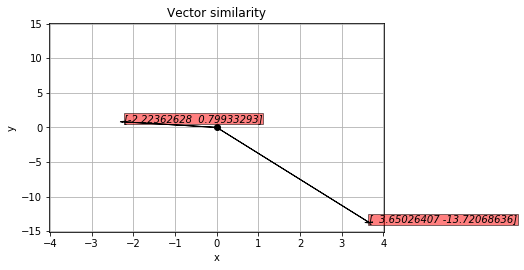

In [14]:
plotv(vectors_queries)

In [37]:
# query
for query in vectors_queries:
  query_reshape = query.reshape(1,2)

  matches = []
  cos_lib = cosine_similarity(query_reshape, a) 
  matches.append(abs(cos_lib[0][0]*100))
  print('Similarity between query and doc0: ', cos_lib[0][0]*100)
  cos_lib = cosine_similarity(query_reshape, b) 
  matches.append(abs(cos_lib[0][0]*100))
  print('Similarity between query and doc1: ', cos_lib[0][0]*100)
  cos_lib = cosine_similarity(query_reshape, c) 
  matches.append(abs(cos_lib[0][0]*100))
  print('Similarity between query and doc2: ', cos_lib[0][0]*100)
  cos_lib = cosine_similarity(query_reshape, d) 
  matches.append(abs(cos_lib[0][0]*100))
  print('Similarity between query and doc3: ', cos_lib[0][0]*100)

  m = max(matches)
  indexes = [i for i, j in enumerate(matches) if j == m]
  for best in indexes:
    print("Best match is doc",best, "with score of", m)

Similarity between query and doc0:  99.90549449648911
Similarity between query and doc1:  99.7026915361413
Similarity between query and doc2:  99.97865961801666
Similarity between query and doc3:  97.42673869887601
Best match is doc 2 with score of 99.97865961801666
Similarity between query and doc0:  -53.25648042662693
Similarity between query and doc1:  -50.37862192532606
Similarity between query and doc2:  -55.17383434452003
Similarity between query and doc3:  -73.95863655494743
Best match is doc 3 with score of 73.95863655494743
